# Imports des bibliothèques

In [ ]:
import imgaug
import time
import numpy as np

import cv2
import os
from tensorflow import keras
from keras.preprocessing import image
from keras.optimizers import Adam


from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


from keras.utils import plot_model, Sequence


from keras.metrics import MeanIoU


from keras.models import Model


from keras.layers import UpSampling2D, Input, Conv2D, MaxPooling2D, Concatenate
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
import mlflow

In [2]:

import warnings
warnings.filterwarnings('ignore')

## Définition de l'environnement

In [3]:
from tensorflow.keras.utils import Sequence, to_categorical, load_img, img_to_array
from concurrent.futures import ThreadPoolExecutor
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from PIL import UnidentifiedImageError
from collections import namedtuple
import utils


Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'catId',
    'hasInstances', 'ignoreInEval', 'color',
])


labels = [

    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label('unlabeled',  0,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('ego vehicle',  1,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('rectification border',  2,      255,
          'void', 0, False, True, (0,  0,  0)),
    Label('out of roi',  3,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('static',  4,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('dynamic',  5,      255, 'void', 0, False, True, (111, 74,  0)),





    Label('ground',  6,      255, 'void', 0, False, True, (81,  0, 81)),





    Label('road',  7,        0, 'flat', 1, False, False, (128, 64, 128)),





    Label('sidewalk',  8,        1, 'flat', 1, False, False, (244, 35, 232)),





    Label('parking',  9,      255, 'flat', 1, False, True, (250, 170, 160)),





    Label('rail track', 10,      255, 'flat', 1, False, True, (230, 150, 140)),





    Label('building', 11,        2, 'construction',
          2, False, False, (70, 70, 70)),





    Label('wall', 12,        3, 'construction',
          2, False, False, (102, 102, 156)),





    Label('fence', 13,        4, 'construction',
          2, False, False, (190, 153, 153)),





    Label('guard rail', 14,      255, 'construction',
          2, False, True, (180, 165, 180)),





    Label('bridge', 15,      255, 'construction',
          2, False, True, (150, 100, 100)),





    Label('tunnel', 16,      255, 'construction',
          2, False, True, (150, 120, 90)),





    Label('pole', 17,        5, 'object', 3, False, False, (153, 153, 153)),





    Label('polegroup', 18,      255, 'object',
          3, False, True, (153, 153, 153)),





    Label('traffic light', 19,        6, 'object',
          3, False, False, (250, 170, 30)),





    Label('traffic sign', 20,        7, 'object',
          3, False, False, (220, 220,  0)),





    Label('vegetation', 21,        8, 'nature',
          4, False, False, (107, 142, 35)),





    Label('terrain', 22,        9, 'nature', 4, False, False, (152, 251, 152)),





    Label('sky', 23,       10, 'sky', 5, False, False, (70, 130, 180)),





    Label('person', 24,       11, 'human', 6, True, False, (220, 20, 60)),





    Label('rider', 25,       12, 'human', 6, True, False, (255,  0,  0)),





    Label('car', 26,       13, 'vehicle', 7, True, False, (0,  0, 142)),





    Label('truck', 27,       14, 'vehicle', 7, True, False, (0,  0, 70)),





    Label('bus', 28,       15, 'vehicle', 7, True, False, (0, 60, 100)),





    Label('caravan', 29,      255, 'vehicle', 7, True, True, (0,  0, 90)),





    Label('trailer', 30,      255, 'vehicle', 7, True, True, (0,  0, 110)),





    Label('train', 31,       16, 'vehicle', 7, True, False, (0, 80, 100)),





    Label('motorcycle', 32,       17, 'vehicle', 7, True, False, (0,  0, 230)),





    Label('bicycle', 33,       18, 'vehicle', 7, True, False, (119, 11, 32)),





    Label('license plate', -1,       -1,
          'vehicle', 7, False, True, (0,  0, 142)),





]


# Création du mapping id vers categoryId


id_to_category_id_mapping = {label.id: label.catId for label in labels}

In [41]:
# Création de la fonction de perte personnalisée
# Peut-être inutile dans le cas de HF
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Fonction de perte de Dice pour la segmentation sémantique.

    Args:
    y_true (tensor): Tensor des étiquettes réelles.
    y_pred (tensor): Tensor des prédictions du modèle.
    smooth (float): Terme de lissage pour éviter la division par zéro.

    Returns:
    float: Perte de Dice.
    """
    # Aplatir les tensors

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(
        y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)

    dice_loss = 1 - tf.reduce_mean(dice, axis=-1)
    return dice_loss

## Load lists of files

In [5]:
# Load images and masks

import utils


image_dir = './Datasets/Images/leftImg8bit/train/'
mask_dir = './Datasets/Masks/gtFine/train'
image_val_dir = './Datasets/Images/leftImg8bit/val'
mask_val_dir = './Datasets/Masks/gtFine/val'
image_test_dir = "./Datasets/Images/leftImg8bit/test"
mask_test_dir = './Datasets/Masks/gtFine/test'


image_list = [file for file in utils.get_file_list(
    image_dir) if file.endswith('_leftImg8bit.png')]

mask_list = [file for file in utils.get_file_list(
    mask_dir) if file.endswith('_labelIds.png')]

image_val_list = [file for file in utils.get_file_list(
    image_val_dir) if file.endswith('_leftImg8bit.png')]

mask_val_list = [file for file in utils.get_file_list(
    mask_val_dir) if file.endswith('_labelIds.png')]

image_test_list = [file for file in utils.get_file_list(
    image_test_dir) if file.endswith('_leftImg8bit.png')]

mask_test_list = [file for file in utils.get_file_list(
    mask_test_dir) if file.endswith('_labelIds.png')]

print(
    f'Images répertoriées: {len(image_list)}\nMasques répertoriés: {len(mask_list)}')
print(
    f'Nombre d\'images de validation : {len(image_val_list)}\nNombre de masques de validation répertoriés : {len(mask_val_list)}')
print(
    f'Nombre d\'images de test : {len(image_test_list)}\nNombre de masques de test : {len(mask_test_list)}')

batch_size = 16
samples = len(image_list)
steps = samples // batch_size
img_height, img_width = 256, 256
classes = 8
filters_n = 64

Images répertoriées: 2975
Masques répertoriés: 2975
Nombre d'images de validation : 500
Nombre de masques de validation répertoriés : 500
Nombre d'images de test : 1525
Nombre de masques de test : 1525


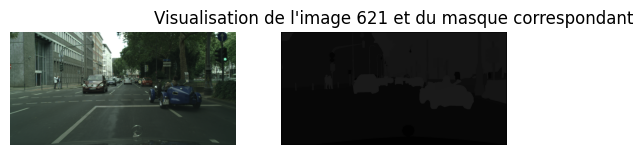

In [6]:
# Valide le chargement des données par visualisation d'un échantillon aléatoire
i = np.random.randint(0, len(image_list))

plt.subplot(1, 2, 1)
plt.imshow(load_img(image_list[i]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(load_img(mask_list[i]))
plt.axis('off')
plt.title(f"Visualisation de l'image {i} et du masque correspondant")
plt.show()

# HuggingFace Transformers Part



## Preprocessing

In [7]:
# Create specific Seg_gen version for HF transformers
import tensorflow as tf
from transformers import pipeline
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imgaug import augmenters as iaa

In [8]:
# Définir la taille cible pour le redimensionnement
target_size = (256, 256)

# Créer train_ds avec la structure souhaitée
train_ds = []
for img_path, mask_path in zip(image_list, mask_list):
    # Charger l'image et le masque et les redimensionner
    image = Image.open(img_path).convert(
        "RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(
        target_size)

    # Créer un élément de dictionnaire
    item = {
        'image': image,
        'annotation': mask
    }

    # Ajouter l'élément à train_ds
    train_ds.append(item)

# Exemple d'accès au premier élément
print(train_ds[0])

{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x1BA0582B010>, 'annotation': <PIL.Image.Image image mode=L size=256x256 at 0x1BA04F90A50>}


In [9]:
# Creation de val_ds

val_ds = []
for img_path, mask_path in zip(image_val_list, mask_val_list):
    # Charger l'image et le masque et les redimensionner
    image = Image.open(img_path).convert(
        "RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(
        target_size)

    # Créer un élément de dictionnaire
    item = {
        'image': image,
        'annotation': mask
    }

    # Ajouter l'élément à train_ds
    val_ds.append(item)

# Exemple d'accès au premier élément
print(val_ds[0])

{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x1BA51C99DD0>, 'annotation': <PIL.Image.Image image mode=L size=256x256 at 0x1BA51C30F90>}


In [10]:
# Creation de test_ds
test_ds = []
for img_path, mask_path in zip(image_test_list, mask_test_list):
    # Charger l'image et le masque et les redimensionner
    image = Image.open(img_path).convert(
        "RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(
        target_size)

    # Créer un élément de dictionnaire
    item = {
        'image': image,
        'annotation': mask
    }

    # Ajouter l'élément à test_ds
    test_ds.append(item)

# Exemple d'accès au premier élément
print(test_ds[0])

{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x1BA3794FC10>, 'annotation': <PIL.Image.Image image mode=L size=256x256 at 0x1BA51D08F90>}


In [11]:
# Create and prepare data for Transformers model
from datasets import Dataset, DatasetDict, Image

image_paths_train = image_list
label_paths_train = mask_list

image_paths_validation = image_val_list
label_paths_validation = mask_val_list

image_paths_test = image_test_list
label_paths_test = mask_test_list


def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

In [12]:
# create Dataset objects

train_dataset = create_dataset(image_paths_train, label_paths_train)

validation_dataset = create_dataset(
    image_paths_validation, label_paths_validation)

test_dataset = create_dataset(image_paths_test, label_paths_test)

# Create a DatasetDict for convenience
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
}
)
# Check
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 2975
    })
    validation: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1525
    })
})

In [112]:
from transformers import AutoImageProcessor


id2label = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
    22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
    32: 7, 33: 7, 34: 7}

label2id = {v: k for k, v in id2label.items()}

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(
    checkpoint, reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [13]:
# ALTERNATIVE depuis GitHub
from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    TFSegformerForSemanticSegmentation)

feature_extractor = SegformerFeatureExtractor(size=256)


def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose((2, 0, 1))
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB"))
              for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [14]:
# ALTERNATIVE (suite)
print('Transformation des données...')

dataset['train'].set_transform(preprocess)
dataset['validation'].set_transform(preprocess)
dataset['test'].set_transform(preprocess)

test_ds = dataset['test']
train_ds = dataset['train']
val_ds = dataset['validation']

data_collator = DefaultDataCollator(return_tensors="tf")

print("OK.Conversion en tf_dataset...")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

test_set = test_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# Look at the shapes of each features within the dataset.
print("OK. Vérification :")
print(f'test_set spec : {test_set.element_spec}')
print(f'Train_set spec : {train_set.element_spec}')
print(f'Val_set spec : {val_set.element_spec}')

Transformation des données...
OK.Conversion en tf_dataset...
OK. Vérification :
test_set spec : {'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None)}
Train_set spec : {'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None)}
Val_set spec : {'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None)}


In [15]:
# Investigate a single batch.
batch = next(iter(train_set))
print(f"batch sizes : {batch['pixel_values'].shape, batch['labels'].shape}")

batch sizes : (TensorShape([16, 3, 256, 256]), TensorShape([16, 256, 256]))


In [104]:
# Importe la mean_iou adaptée
import evaluate


metric = evaluate.load("mean_iou")

In [109]:
# Function to prepare predictions for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )

    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=35,
        ignore_index=-1,
        reduce_labels=image_processor.do_reduce_labels,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update(
        {f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update(
        {f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    return {"val_" + k: v for k, v in metrics.items()}

## Prepare for training

In [34]:
# Define optimizer, learning_rate schedule
from transformers import create_optimizer

batch_size = 16
num_epochs = 10
num_train_steps = 2975 * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [26]:
# Load and compile the model
from transformers import TFAutoModelForSemanticSegmentation
num_labels = len(id2label)
model_checkpoint = "nvidia/mit-b0"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels=num_labels
)
model.compile(optimizer=optimizer)  # No loss needed
print('============\nModel compiled successfully.\n==============')

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model compiled successfully.


In [27]:
num_labels

35

In [28]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  404259    
 codeHead)                                                       
                                                                 
Total params: 3723651 (14.20 MB)
Trainable params: 3723139 (14.20 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [29]:
# Dummy forward pass.
outputs = model(batch)
outputs.loss, outputs.logits.shape

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.4074163], dtype=float32)>,
 TensorShape([16, 35, 64, 64]))

In [32]:
# ALTERNATIVE (suite)

callbacks = [metric_callback]

In [103]:
import gc
gc.collect()

2851

## Train the model


In [34]:
# ALTERNATIVE (suite)

# To keep the runtime of this example short, we will train it for only two epochs.
# For real applications purposes, note that you will likely need a longer training schedule.

mlflow.set_experiment('Huggingface_model')
mlflow.autolog()


model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=10,
)

print('Model trained successfully')

2024/04/15 09:33:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/04/15 09:33:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/04/15 09:33:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2024/04/15 09:33:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/04/15 09:33:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/15 09:33:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgr

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

186/186 [==============================] - 3236s 17s/step - loss: 1.1459 - val_loss: 0.7653 - val_mean_iou: 0.0063 - val_mean_accuracy: 0.0600 - val_overall_accuracy: 0.0212 - val_accuracy_0: 7.8882e-06 - val_accuracy_1: 0.0000e+00 - val_accuracy_2: 0.0000e+00 - val_accuracy_3: 0.0000e+00 - val_accuracy_4: 0.0000e+00 - val_accuracy_5: 9.6859e-05 - val_accuracy_6: 0.0000e+00 - val_accuracy_7: nan - val_iou_0: 7.8840e-06 - val_iou_1: 0.0000e+00 - val_iou_2: 0.0000e+00 - val_iou_3: 0.0000e+00 - val_iou_4: 0.0000e+00 - val_iou_5: 2.5574e-05 - val_iou_6: 0.0000e+00 - val_iou_7: nan
Epoch 2/10
186/186 [==============================] - 2965s 16s/step - loss: 0.6949 - val_loss: 0.6492 - val_mean_iou: 0.0069 - 

## Evaluate the model

In [54]:
# Evaluate the model

model.evaluate(test_set)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got LayerCall
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got LayerCall
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got LayerCall
To silence this warning, deco

9.526201248168945

In [55]:
# Predict test data
predictions = model.predict(test_set)

96/96 [==============================] - 864s 9s/step


In [ ]:
# Compute metrics
compute_metrics(predictions)

# Inference

In [38]:
pretrained_model = TFSegformerForSemanticSegmentation.from_pretrained(
    "Modèles/Data Augmentation/HF_model")
pretrained_model.compile()

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [117]:
# Normalization function for inference image
def normalize_image(image):

    image_np = np.array(image)
    # Normalisation Min-Max pour ramener les valeurs entre 0 et 1
    normalized_image = (image_np - image_np.min()) / \
        (image_np.max() - image_np.min())
    return normalized_image

In [118]:
# Select a random image in the test set
inference = test_ds

i = np.random.randint(0, len(inference))


inference.set_transform(preprocess)
test_image = inference[i]["pixel_values"]
test_gt = inference[i]['labels']
print(test_image.shape)

(3, 256, 256)


In [119]:
test_image = normalize_image(test_image)
inputs = feature_extractor(
    images=test_image, return_tensors="tf", do_rescale=False)
print(inputs["pixel_values"].shape)

(1, 3, 256, 256)


In [120]:
# Collect original dimensions

original_size = img_to_array(load_img(image_test_list[0])).shape
original_size

(1024, 2048, 3)

In [121]:
outputs = pretrained_model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
print(f"Raw logits shape :{logits.shape}")

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])
print(f"Transposed logits shape : {logits.shape}")
# First, rescale logits to original image size

upsampled_logits = tf.image.resize(
    logits,
    size=(256, 256))
"""test_image.size[  # test_image.size
    ::-1
],  # We reverse the shape of `image` because `image.size` returns width and height.
)
"""
print(f'upsampled_logits shape: {upsampled_logits.shape}')


# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]  # upsampled_logits
print(f'pred_seg.shape = {pred_seg.shape}')

Raw logits shape :(1, 35, 64, 64)
Transposed logits shape : (1, 64, 64, 35)
upsampled_logits shape: (1, 256, 256, 35)
pred_seg.shape = (256, 256)


In [122]:
# Utilities function for visualisation
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]


def get_seg_overlay(image, seg):
    """Format predicted and GT mask to overlay the original image.

    Args:
        image (np.array): predicted image
        seg (np.array):  predicted mask or Ground Truth mask

    Returns:
        np.array: 
    """

    if image.shape[0] == 3:  # Assuming 3 channels
        image = np.transpose(image, (1, 2, 0))

    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

In [108]:
colored_gt_list = [file for file in utils.get_file_list(
    mask_test_dir) if file.endswith('_colors.png')]

In [110]:
test_image_raw = load_img(image_test_list[i])
test_gt_raw = load_img(mask_test_list[i])

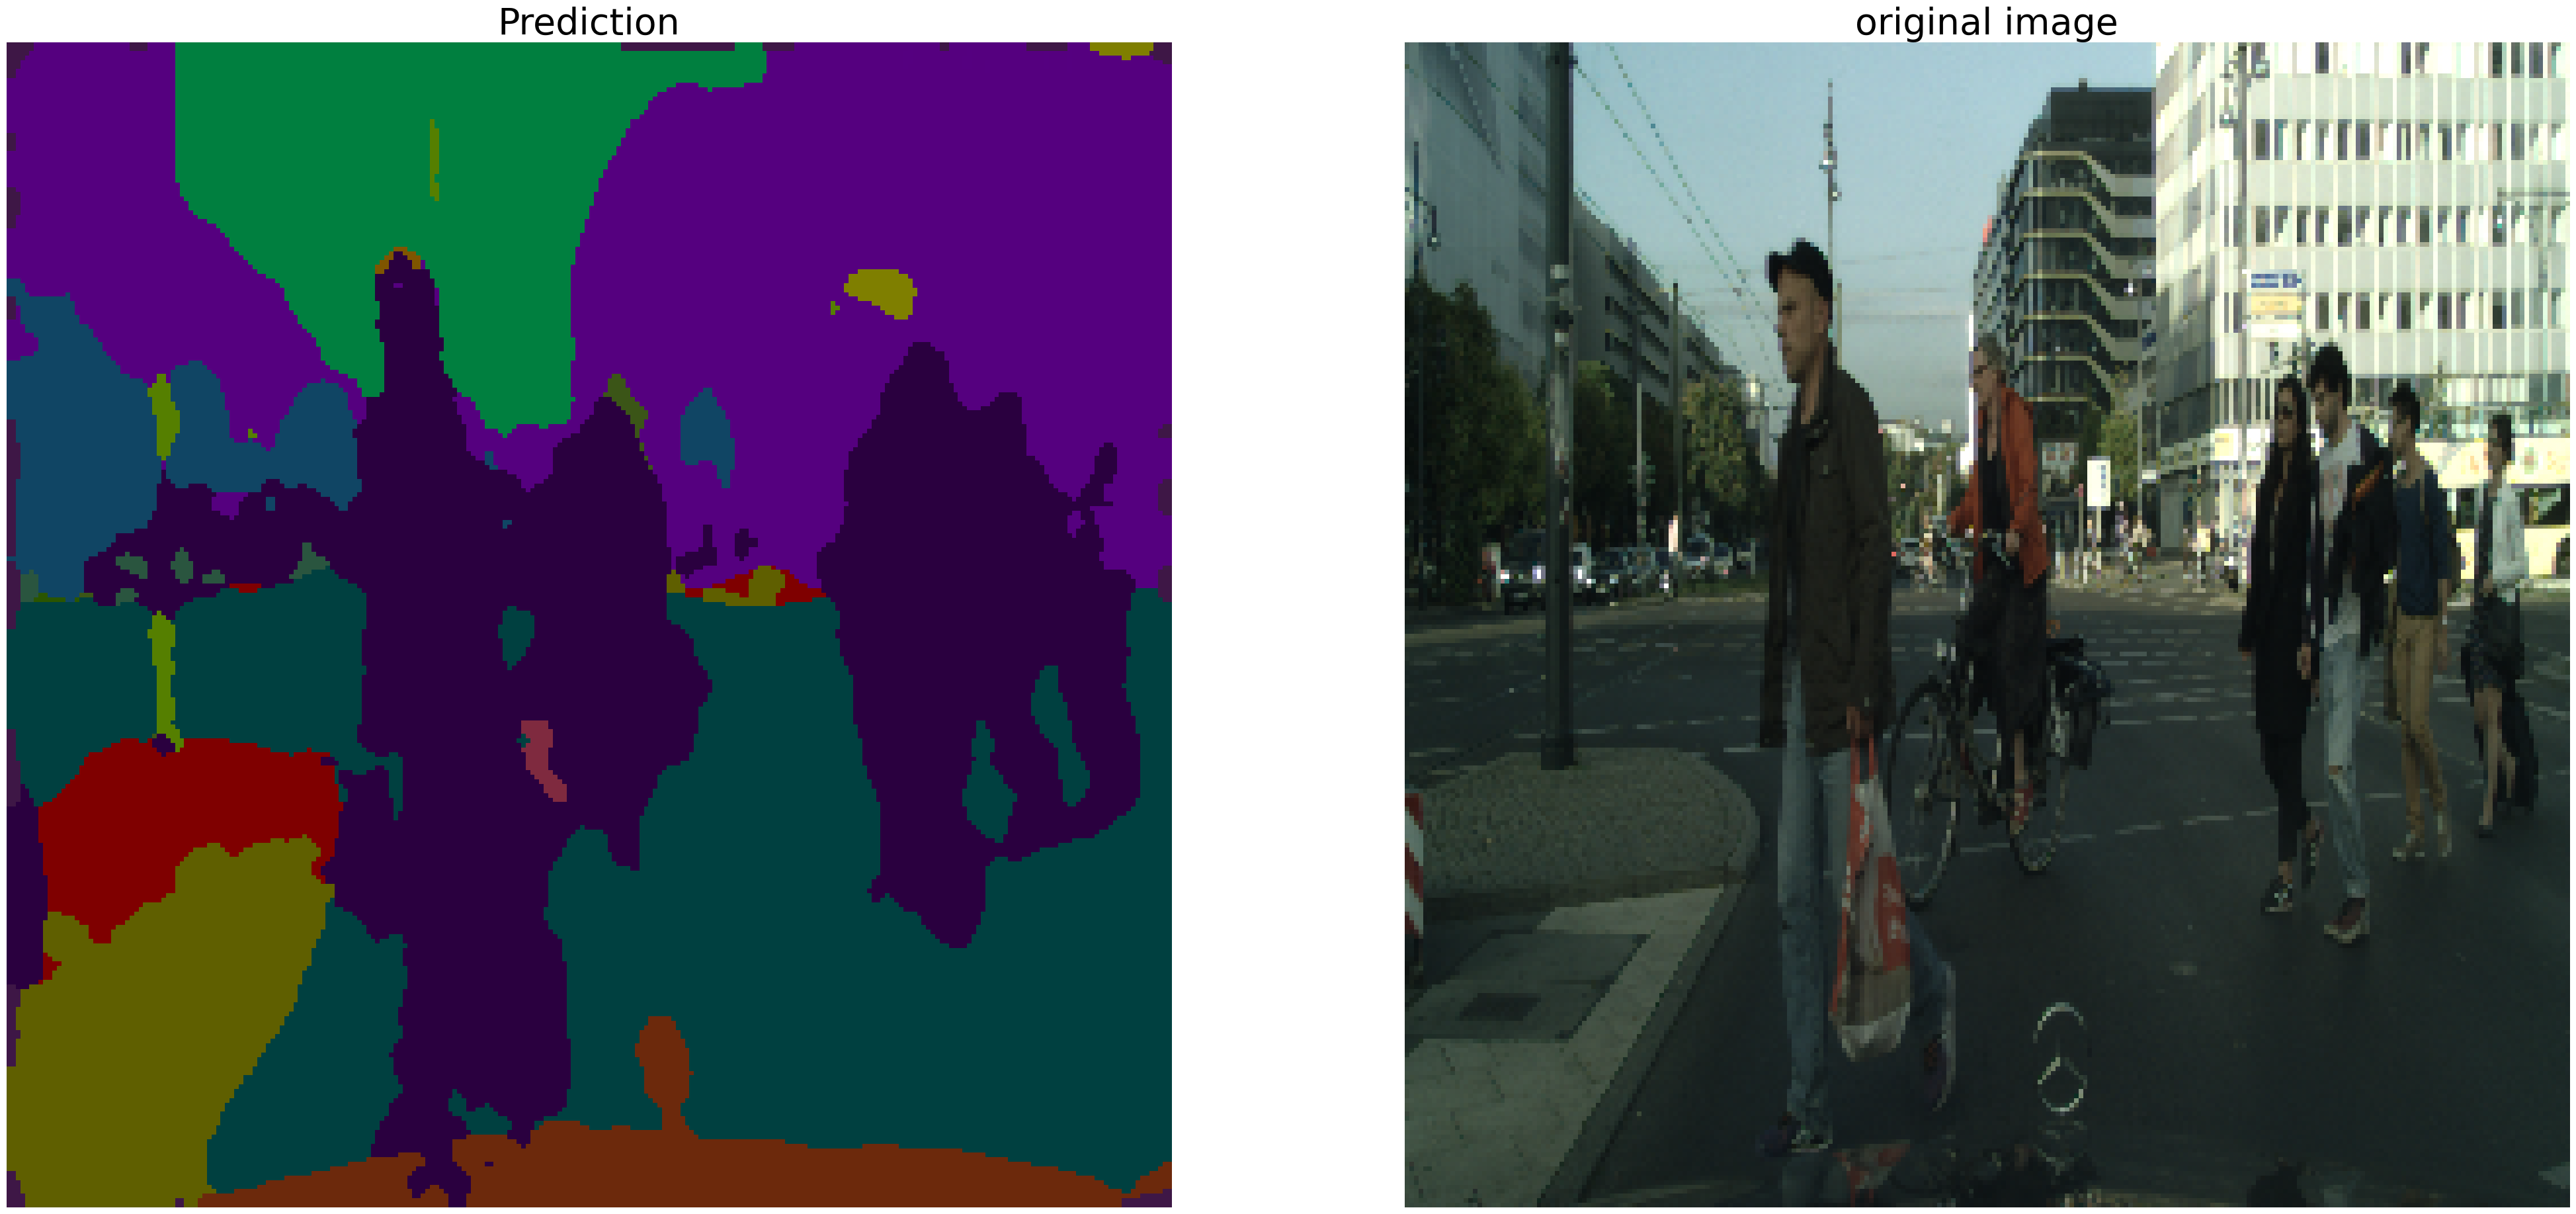

In [123]:
# Visualize predictions
pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("original image", {"fontsize": 40})
axs[1].imshow(load_img(image_test_list[i], target_size=(256, 256)))
axs[1].axis("off")

plt.show()

## MLflow ui

In [124]:
import gc
gc.collect()

5999

# Optimisation


## Hyperparameter tuning

In [88]:
# Load and compile the model
from transformers import TFAutoModelForSemanticSegmentation


model = TFSegformerForSemanticSegmentation.from_pretrained(
    'Modèles/Data Augmentation/HF_model'
)
model.compile(optimizer=optimizer)  # No loss needed
param_grid = {
    'loss_function': [
        SparseCategoricalCrossentropy(from_logits=True),
        dice_loss,
        focal_loss()
    ],
    'epochs': [20, 30, 50]
}

model.compile(optimizer=optimizer, loss=param_grid['loss_function'])

print('============\nModel compiled successfully.\n==============')

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


Model compiled successfully.


In [58]:
len(train_set)//32

5

In [110]:
from transformers import create_optimizer
import os
import mlflow
from transformers import TFSegformerForSemanticSegmentation, create_optimizer
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from transformers.keras_callbacks import KerasMetricCallback
from tensorflow.keras.metrics import MeanIoU, Accuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy


tf.config.experimental_run_functions_eagerly(True)


def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_pred = tf.math.log(y_pred / (1 - y_pred))
        alpha_t = y_true*alpha + \
            (tf.keras.backend.ones_like(y_true) - y_true)*(1-alpha)
        loss = tf.reduce_mean(-alpha_t * tf.pow(
            (tf.keras.backend.ones_like(y_true) - y_pred), gamma) * y_true)
        return loss
    return focal_loss_fixed


param_grid = {
    'epochs': [20, 30, 50]
}


def reinitialize_model():
    return TFSegformerForSemanticSegmentation.from_pretrained('Modèles/Data Augmentation/HF_model')


# Define optimizer, learning_rate schedule

batch_size = 16
num_epochs = 10
num_train_steps = 2975 * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_set,
    batch_size=32,
    label_cols=["labels"],
)


def optimize_hyperparameters(model, train_data, val_data, param_grid, initial_lr=1e-4):
    # Configurer MLflow
    mlflow.set_experiment('Optimisation_HF')

    best_loss = float('inf')
    best_params = None
    best_model = None

    with mlflow.start_run():
        for params in ParameterGrid(param_grid):
            with mlflow.start_run(nested=True):
                print('==============New run==============')

                steps_per_epoch = 5  # len(train_data) // 32
                total_training_steps = steps_per_epoch * params['epochs']

                optimizer, _ = create_optimizer(init_lr=6e-5,  # optimizer
                                                num_train_steps=steps_per_epoch,
                                                weight_decay_rate=0.01,
                                                num_warmup_steps=0,
                                                )

                # early_stopping = tf.keras.callbacks.EarlyStopping(
                #   monitor='val_loss', patience=3, verbose=1, mode='min')
                print('==============Reinitialize_model...==============')
                model = reinitialize_model()
                # , metrics=[MeanIoU(num_classes=35), 'accuracy']
                model.compile(optimizer=optimizer,
                              )  # loss=params['loss_function']
                print(
                    '==============Done.==============\n==============Training...==============')
                history = model.fit(
                    train_data,
                    epochs=params['epochs'],
                    validation_data=val_data,
                    batch_size=32,
                    callbacks=[metric_callback]  # early_stopping
                )

                print(
                    '==============Model trained.Get final_epochs score...==============')
                final_epoch_loss = history.history['loss'][-1]
                print('==============Scores saved. Register to MLflow...==============')
                # Enregistrement des paramètres et des métriques dans MLflow

                """
                mlflow.log_params(params)
                mlflow.log_metrics({
                    'loss': final_epoch_loss,
                })
                
                'iou': history.history['mean_iou'][-1],
                    'dice_loss': history.history['dice_loss'][-1],
                    'accuracy': history.history['accuracy'][-1]})
                    mlflow.keras.log_model(model, "model")
                """

                print('==============Metrics and current model saved==============')
                if final_epoch_loss < best_loss:
                    best_loss = final_epoch_loss
                    best_params = params
                    best_model = model
                print('==============Run successful==============')
    return {'best_params': best_params, 'best_loss': best_loss, 'best_model': model}

In [113]:
mlflow.autolog()
optimize_hyperparameters(
    model, train_data=train_set, val_data=val_set, param_grid=param_grid)

2024/04/18 13:44:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/18 13:44:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/04/18 13:44:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/04/18 13:44:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2024/04/18 13:44:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/04/18 13:44:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try

==============New run==============
==============Reinitialize_model...==============


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


==============Done.==============
==============Training...==============
Epoch 1/20
186/186 [==============================] - 2591s 14s/step - loss: 0.4123 - val_loss: 0.5152 - val_mean_iou: 0.0099 - val_mean_accuracy: 0.0664 - val_overall_accuracy: 0.0163 - val_accuracy_0: 0.0054 - val_accuracy_1: 4.7845e-07 - val_accuracy_2: 0.0000e+00 - val_accuracy_3: 9.4901e-04 - val_accuracy_4: 0.0000e+00 - val_accuracy_5: 7.8025e-05 - val_accuracy_6: 2.2844e-04 - val_accuracy_7: nan - val_iou_0: 0.0054 - val_iou_1: 4.7767e-07 - val_iou_2: 0.0000e+00 - val_iou_3: 9.3748e-04 - val_iou_4: 0.0000e+00 - val_iou_5: 2.0931e-05 - val_iou_6: 2.2780e-04 - val_iou_7: nan
Epoch 2/20
186/186 [==============================] - 2779s 15s/step - loss: 0.4108 - val_loss: 0.5152 - val_mean_iou: 0.0098 - val_mean_accuracy: 0.0660 - val_overall_accuracy: 0.0161 - val_accuracy_0: 0.0053 - val_accuracy_1: 1.5948e-07 - val_accuracy_2: 0.0000e+00 - val_accuracy_3: 8.4959e-04 - val_accuracy_4: 0.0000e+00 - val_accurac

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at Modèles/Data Augmentation/HF_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


==============Done.==============
==============Training...==============
Epoch 1/30
 26/186 [===>..........................] - ETA: 31:32 - loss: 0.4183

KeyboardInterrupt: 

In [24]:
# Save best model
model.save_pretrained("best_hf_model")

## Evaluation and inference

In [ ]:
# Utilities function for visualisation
from transformers import SegformerFeatureExtractor
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img
import cv2

feature_extractor = SegformerFeatureExtractor(size=256)


def transforms(image):
    # Convert image to numpy array and transpose the color channel
    image = tf.keras.utils.img_to_array(image)
    image = np.transpose(image, (2, 0, 1))
    return image


def preprocess(example_batch):
    # Transform and preprocess the batch of images
    images = [transforms(x.convert("RGB"))
              for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs


def normalize_image(image):
    # Normalize image
    image_np = np.array(image)
    normalized_image = (image_np - image_np.min()) / \
        (image_np.max() - image_np.min())
    return normalized_image


def get_seg_overlay(image, seg):

    # Get color overlay on the segmented image using class_colors
    image = np.transpose(image, (1, 2, 0))  # Revert the color channel back
    print(f"Image shape : {np.array(image).shape}")

    # Resize the image to the desired output dimensions (1024, 2048)
    resized_image = cv2.resize(
        image, (2048, 1024), interpolation=cv2.INTER_LINEAR)
    print("Resized image shape:", resized_image.shape)

    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    print(f"Color_seg shape : {color_seg.shape}")

    # Apply colors based on the segmentation map
    for label, color in class_colors.items():
        color_seg[seg == label, :] = color
    img = resized_image * 0.5 + color_seg * 0.5
    return img.astype(np.uint8)


def visualize_hf_prediction(test_ds, feature_extractor, pretrained_model):
    # Visualize prediction and the original image
    # i = np.random.randint(0, len(test_ds))
    test_ds.set_transform(preprocess)
    test_image = test_ds['test'][6]["pixel_values"]
    test_gt = test_ds['test'][6]['labels']
    test_image = normalize_image(test_image)

    # Prepare image input for the model prediction
    inputs = feature_extractor(
        images=test_image, return_tensors="tf", do_rescale=False)
    outputs = pretrained_model(**inputs)
    logits = outputs.logits
    logits = tf.transpose(logits, [0, 2, 3, 1])

    # Resize logits to original image size and apply argmax
    upsampled_logits = tf.image.resize(logits, size=(1024, 2048))
    pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]

    # Apply label mapping
    pred_seg_mapped = np.vectorize(id2label.get)(pred_seg.numpy())

    print("Unique predicted labels:", np.unique(pred_seg_mapped))

    # Apply color overlay using class_colors palette
    pred_img = get_seg_overlay(test_image, pred_seg_mapped)
    # gt_img = get_seg_overlay(test_image, np.array(test_gt))

    # Print the dimensions to verify
    print(f"Dimensions of the predicted image: {pred_img.shape}")

    # Display the images
    f, axs = plt.subplots(1, 2, figsize=(50, 30))
    axs[0].imshow(pred_img)
    axs[0].set_title("Prediction", fontsize=40)
    axs[0].axis("off")
    axs[1].imshow(load_img(image_list[6], target_size=(1024, 2048)))
    axs[1].set_title("Original Image", fontsize=40)
    axs[1].axis("off")
    plt.show()


id2label = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
    22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
    32: 7, 33: 7, 34: 7}

class_colors = {
    0: (0, 0, 0),       # Classe 0 : Noir - Background/Void
    1: (128, 0, 0),     # Classe 1 : Rouge Foncé - Flat
    2: (0, 128, 0),     # Classe 2 : Vert Foncé - Sky
    3: (128, 128, 0),   # Classe 3 : Olive - Human
    4: (0, 0, 128),     # Classe 4 : Bleu Foncé - Vehicle
    5: (128, 0, 128),   # Classe 5 : Pourpre - Object
    6: (0, 128, 128),   # Classe 6 : Teal - Construction
    7: (128, 128, 128)  # Classe 7 : Gris - Nature
}

In [ ]:
# Example usage
visualize_hf_prediction(dataset, feature_extractor, hf_model)

# Nettoyage

In [2]:
# Nettoyage des fichiers desktop.ini créés en local
# A effectuer avant toute visualisation
import glob
import os

# Définir le chemin de base où rechercher les fichiers `desktop.ini`
base_path = "mlruns/**/desktop.ini"

# Utiliser `glob.glob` avec l'option `recursive=True` pour trouver tous les fichiers correspondants
# dans le dossier et ses sous-dossiers.
desktop_ini_files = glob.glob(base_path, recursive=True)

# Parcourir la liste des chemins de fichiers trouvés et les supprimer
for file_path in desktop_ini_files:
    os.remove(file_path)
    print(f"Deleted: {file_path}")

# Note: Assurez-vous que le chemin `base_path` est correct et que vous souhaitez supprimer ces fichiers
# avant d'exécuter le script.